In [17]:
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import model_selection
from sklearn.metrics import confusion_matrix 
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn import preprocessing
import seaborn as sns
from sklearn.decomposition import PCA

from time_domain_features import *
from frequency_domain_features import *

warnings.filterwarnings('ignore')

# Preparing raw data from 22 subjects

In [2]:
files = os.listdir('User Identification From Walking Activity')
df = pd.read_csv('User Identification From Walking Activity/1.csv',header=None)
df.columns = ['timestep','x','y','z']
df['mag_acc'] = (df['x']**2 + df['y']**2 + df['z']**2)**0.5
df['label'] = '1'
print(df.head(5))
for file in files:
    if 'csv' not in file:
        continue
    filename = file.split('.')[0]
    if filename =='1':
        continue
    data = pd.read_csv('User Identification From Walking Activity/' + file, header=None)
    data.columns = ['timestep','x','y','z']
    data['mag_acc'] = (data['x']**2 + data['y']**2 + data['z']**2)**0.5
    data['label'] = filename
    
    df = df.append(data, ignore_index=True)

   timestep        x        y        z    mag_acc label
0  0.000000  0.69464  3.17350   7.5048   8.177753     1
1  0.030639  0.14982  3.48680   9.2755   9.910354     1
2  0.069763 -0.29965  1.94770   9.1120   9.322654     1
3  0.099823 -1.68890  1.41650  10.1200  10.357280     1
4  0.129820 -2.17930  0.95342  10.9240  11.179988     1


['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22']
17    21991
18    20758
20    16949
14    12027
22     9698
9      7988
4      6981
13     6699
11     5636
1      5069
6      4936
12     4799
2      3882
7      3729
15     3653
8      3457
10     3086
21     3082
16     1728
3      1144
5      1129
19      911
Name: label, dtype: int64


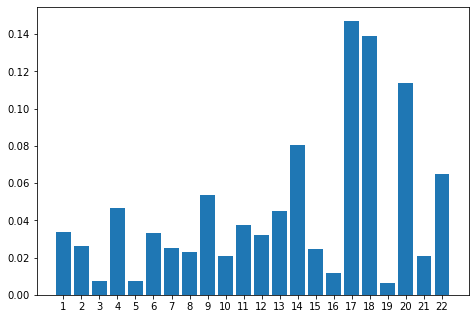

In [3]:
labels = list(df['label'].unique())
labels = sorted(labels, key = lambda x: int(x))
print (labels)
list_count = []
for i in labels:
    count = sum(df['label'] == i)
    list_count.append(count/len(df))
print (df.label.value_counts())   
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
person = labels
count = list_count
ax.bar(person,count)
plt.show()

# Plotting standardized magnitude of acceleration

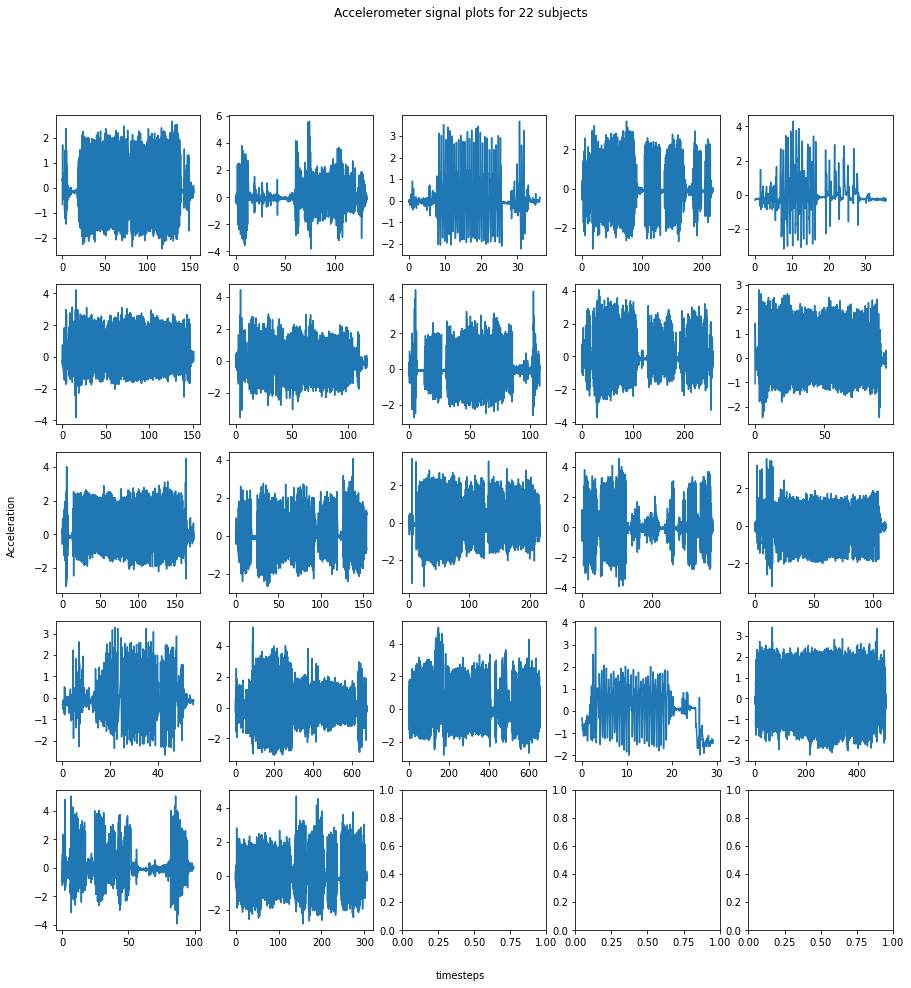

In [4]:
fig, axs = plt.subplots(5, 5,figsize=(15,15))
fig.text(0.5, 0.08, 'timesteps', ha='center')
fig.text(0.08, 0.5, 'Acceleration', va='center', rotation='vertical')
fig.suptitle('Accelerometer signal plots for 22 subjects', fontsize=12)
count = 0
for i in range(5):
    for j in range(5):
        count += 1
        if i==4 and count>22:
            break
        y_val = df[df['label'] == str(count)].mag_acc.values
        y_val = (y_val - np.mean(y_val))/np.std(y_val)
        x_val = df[df['label'] == str(count)].timestep.values
        axs[i,j].plot(x_val,y_val)

# Extracting time domain features

Features are calculated by taking a window of length 100 samples and an overlap of 50%. These include the following

- Means of x component, y component and z component of accelaration
- Min values of x component, y component and z component of accelaration
- Max values of x component, y component and z component of accelaration
- Mean of magnitude of accelearation
- Min of magnitude of acceleration
- Max of magnitude of acceleration
- Median of magnitude of acceleration
- Ratio of mean of x component and mean of z component
- Ratio of mean of y component and mean of z component
- Average of time difference between consecutive readings


In [5]:
cols = ['x_mean','y_mean','z_mean','x_min','y_min','z_min','x_max','y_max',\
        'z_max','mag_mean','mag_min','mag_max','mag_median','cc_xz', 'cc_yz', 'time_diff','label']
feature_df = pd.DataFrame(columns = cols)
for label in df.label.unique():
    dict_cols = {}
    one_label_df = df[df['label'] == label]
    windows = separate_windows(one_label_df)
    dict_cols = {'label':[label]*len(windows)}
    dict_cols.update(min_max_mean_each_component(windows))
    dict_cols.update(min_max_mean_magnitude(windows))
    dict_cols.update(cross_correlation(windows))
    dict_cols.update(avg_time_bw_obs(windows))
    temp_df = pd.DataFrame(dict_cols)
    feature_df = feature_df.append(temp_df, ignore_index=True)   
print(feature_df.head(5))

     x_mean    y_mean    z_mean   x_min    y_min   z_min     x_max   y_max  \
0 -1.734232  4.632127  7.920713 -5.0940  0.10896  1.9205   3.44590  14.206   
1  0.138899  6.795479  4.453044 -5.0940  2.07030 -3.7592  10.14700  14.206   
2  0.307064  8.404446  1.289750 -5.2030  2.07030 -3.7592  10.14700  14.015   
3 -2.143921  9.415441 -0.580550 -5.2030  5.74780 -3.7592   0.50395  14.015   
4 -2.486993  9.265743 -0.782160 -3.6775  8.43100 -2.9148  -1.07600  10.038   

      z_max   mag_mean   mag_min    mag_max  mag_median     cc_xz      cc_yz  \
0  12.59900  10.077637  6.992364  15.105099    9.874912 -0.218949   0.584812   
1   9.80660   9.897306  5.866069  17.011228    9.834211  0.031192   1.526030   
2   8.68980   9.817103  5.866069  17.011228    9.834211  0.238080   6.516335   
3   4.79440   9.830692  6.960874  14.473038    9.802116  3.692911 -16.218131   
4   0.31327   9.667818  8.809474  10.328538    9.673252  3.179649 -11.846358   

   time_diff label  x_median  y_median  z_median  

In [6]:
test = feature_df[feature_df['label'] == '22']
test.time_diff.values

array([0.031405, 0.034201, 0.033197, 0.030398, 0.029999, 0.031099,
       0.032799, 0.0319  , 0.0304  , 0.0305  , 0.032   , 0.0325  ,
       0.0318  , 0.0313  , 0.0307  , 0.03058 , 0.03181 , 0.03273 ,
       0.03249 , 0.033   , 0.03401 , 0.03389 , 0.03169 , 0.03198 ,
       0.0325  , 0.03102 , 0.0304  , 0.0302  , 0.0304  , 0.0322  ,
       0.0319  , 0.0302  , 0.0302  , 0.0301  , 0.0301  , 0.03    ,
       0.0322  , 0.0323  , 0.0304  , 0.0306  , 0.0306  , 0.0304  ,
       0.0303  , 0.0306  , 0.0304  , 0.03018 , 0.0304  , 0.03082 ,
       0.0313  , 0.0307  , 0.0306  , 0.0312  , 0.0309  , 0.0304  ,
       0.0301  , 0.0302  , 0.0308  , 0.0307  , 0.0302  , 0.0301  ,
       0.03    , 0.0302  , 0.0305  , 0.0311  , 0.031   , 0.0302  ,
       0.03    , 0.0307  , 0.0307  , 0.03    , 0.0408  , 0.0408  ,
       0.03    , 0.0301  , 0.043   , 0.0442  , 0.0315  , 0.0305  ,
       0.0326  , 0.0369  , 0.0353  , 0.0314  , 0.0312  , 0.0319  ,
       0.034   , 0.0336  , 0.031   , 0.0302  , 0.0303  , 0.033

# Train test split

In [7]:
dataframe = feature_df
features = dataframe.loc[:, dataframe.columns != 'label']
labels = dataframe['label']
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.30)

In [8]:
labels = list(set(feature_df.label.values))

# Model Training

## Base model

Base model a logistic regression model and is made using only features - average maginitude of acceleration and average time between consecutive readings 

In [9]:
X = x_train[['mag_mean','time_diff']]
X_test = x_test[['mag_mean','time_diff']] 
model = OneVsRestClassifier(LogisticRegression())
model = model.fit(X, y_train)
scores = model.predict(X_test)
print ("Accuracy of base model on train set is {0:.4f}".format(model.score(X, y_train)))
print ("Accuracy of base model on test set is {0:.4f}".format(model.score(X_test,y_test)))

Accuracy of base model on train set is 0.1816
Accuracy of base model on test set is 0.1738


              precision    recall  f1-score   support

           1       0.00      0.00      0.00        34
           2       0.00      0.00      0.00        15
           3       0.00      0.00      0.00        28
           4       0.00      0.00      0.00        36
           5       0.00      0.00      0.00        46
           6       0.31      0.39      0.35        77
           7       0.00      0.00      0.00        26
           8       0.00      0.00      0.00         9
           9       0.14      0.55      0.22       138
          10       0.20      0.42      0.27       114
          11       0.00      0.00      0.00         4
          12       0.00      0.00      0.00        24
          13       0.00      0.00      0.00       105
          14       0.00      0.00      0.00        13
          15       0.00      0.00      0.00        57
          16       0.00      0.00      0.00         4
          17       0.00      0.00      0.00        39
          18       0.00    

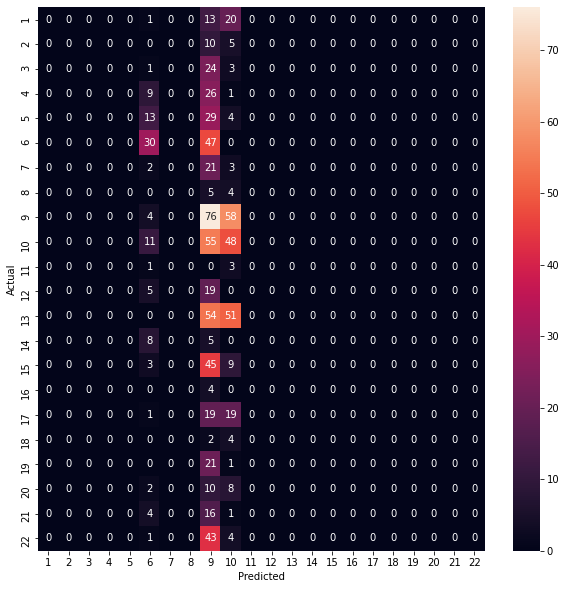

In [10]:
a = sorted(labels,key = lambda x: int(x))
print(classification_report(y_test, model.predict(X_test), target_names=a))
cfm = confusion_matrix(y_test, model.predict(X_test))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cfm, annot=True, fmt='d',
            xticklabels=a, yticklabels=a)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Logistic regression

              precision    recall  f1-score   support

           1       0.52      0.32      0.40        34
           2       0.68      0.87      0.76        15
           3       0.00      0.00      0.00        28
           4       0.00      0.00      0.00        36
           5       0.87      0.74      0.80        46
           6       0.91      0.94      0.92        77
           7       0.84      0.62      0.71        26
           8       0.00      0.00      0.00         9
           9       0.44      0.55      0.49       138
          10       0.55      0.76      0.64       114
          11       1.00      0.25      0.40         4
          12       0.44      0.17      0.24        24
          13       0.70      0.93      0.80       105
          14       0.53      0.69      0.60        13
          15       0.59      0.75      0.66        57
          16       0.50      0.50      0.50         4
          17       0.57      0.31      0.40        39
          18       0.40    

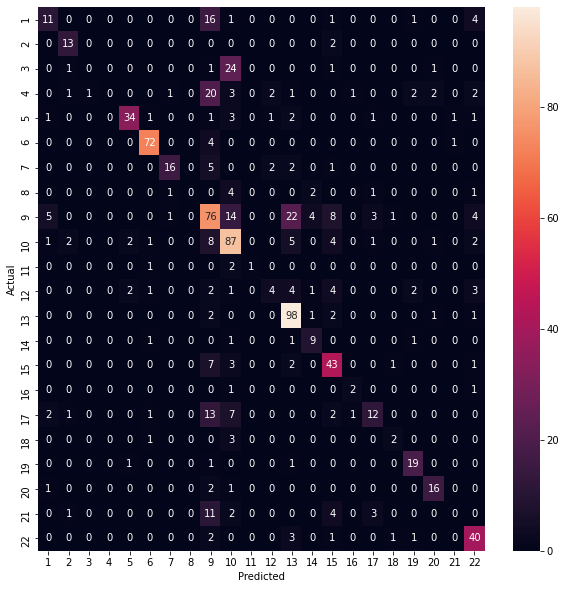

In [11]:
lr = OneVsRestClassifier(LogisticRegression())
lr = lr.fit(x_train, y_train)
scores = lr.predict(x_test)
a = sorted(labels,key = lambda x: int(x))
print(classification_report(y_test, lr.predict(x_test), target_names=a))
cfm_lr = confusion_matrix(y_test, lr.predict(x_test))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cfm_lr, annot=True, fmt='d',
            xticklabels=a, yticklabels=a)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Random forest without hyperparameter training

In [12]:
clf = OneVsRestClassifier(RandomForestClassifier(max_depth=2, random_state=0))
clf = clf.fit(x_train,y_train)

              precision    recall  f1-score   support

           1       0.96      0.74      0.83        34
           2       0.91      0.67      0.77        15
           3       0.72      0.64      0.68        28
           4       1.00      0.39      0.56        36
           5       0.72      0.78      0.75        46
           6       0.68      0.94      0.79        77
           7       0.94      0.58      0.71        26
           8       0.00      0.00      0.00         9
           9       0.63      0.55      0.59       138
          10       0.62      0.75      0.67       114
          11       1.00      0.50      0.67         4
          12       0.83      0.21      0.33        24
          13       0.61      0.97      0.75       105
          14       0.80      0.31      0.44        13
          15       0.59      0.82      0.69        57
          16       1.00      0.75      0.86         4
          17       0.60      0.15      0.24        39
          18       0.80    

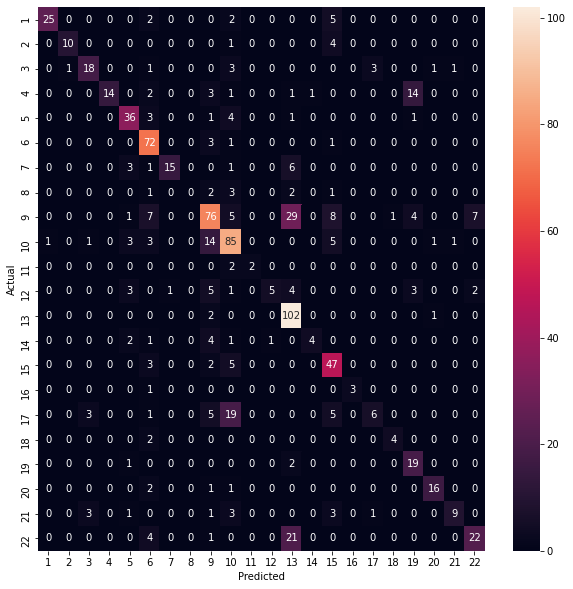

In [13]:
print(classification_report(y_test, clf.predict(x_test), target_names=a))
cfm_clf = confusion_matrix(y_test, clf.predict(x_test))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cfm_clf, annot=True, fmt='d',
            xticklabels=a, yticklabels=a)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Random forest with hyperparameter training

In [14]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,15,25]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,6,8,10]
# Method of selecting samples for training each tree
bootstrap = [True, False]
random_grid = {'estimator__n_estimators': n_estimators,
               'estimator__max_features': max_features,
               'estimator__max_depth': max_depth,
               'estimator__min_samples_split': min_samples_split,
               'estimator__min_samples_leaf': min_samples_leaf,
               'estimator__bootstrap': bootstrap}
print(random_grid)

{'estimator__n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000], 'estimator__max_features': ['auto', 'sqrt'], 'estimator__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'estimator__min_samples_split': [2, 5, 10, 15, 25], 'estimator__min_samples_leaf': [1, 2, 4, 6, 8, 10], 'estimator__bootstrap': [True, False]}


In [15]:
rf_randomCV = OneVsRestClassifier(RandomForestClassifier())
print (rf_randomCV.get_params().keys())
rf_random = RandomizedSearchCV(estimator = rf_randomCV, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random = rf_random.fit(x_train, y_train)

dict_keys(['estimator__bootstrap', 'estimator__ccp_alpha', 'estimator__class_weight', 'estimator__criterion', 'estimator__max_depth', 'estimator__max_features', 'estimator__max_leaf_nodes', 'estimator__max_samples', 'estimator__min_impurity_decrease', 'estimator__min_impurity_split', 'estimator__min_samples_leaf', 'estimator__min_samples_split', 'estimator__min_weight_fraction_leaf', 'estimator__n_estimators', 'estimator__n_jobs', 'estimator__oob_score', 'estimator__random_state', 'estimator__verbose', 'estimator__warm_start', 'estimator', 'n_jobs'])
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 51.1min finished


              precision    recall  f1-score   support

           1       1.00      0.88      0.94        34
           2       0.93      0.93      0.93        15
           3       0.89      0.89      0.89        28
           4       0.91      0.89      0.90        36
           5       0.95      0.76      0.84        46
           6       0.91      0.92      0.92        77
           7       0.92      0.85      0.88        26
           8       0.80      0.44      0.57         9
           9       0.83      0.93      0.88       138
          10       0.87      0.95      0.91       114
          11       1.00      0.75      0.86         4
          12       0.79      0.46      0.58        24
          13       0.96      0.93      0.95       105
          14       0.62      0.77      0.69        13
          15       0.93      0.89      0.91        57
          16       0.60      0.75      0.67         4
          17       0.80      0.82      0.81        39
          18       0.86    

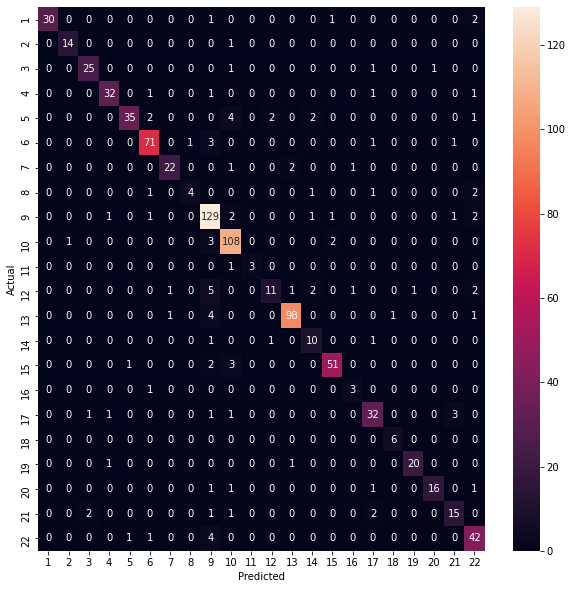

In [16]:
print(classification_report(y_test, rf_random.predict(x_test), target_names=a))
cfm_rf_random = confusion_matrix(y_test, rf_random.predict(x_test))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cfm_rf_random, annot=True, fmt='d',
            xticklabels=a, yticklabels=a)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## AdaBoost classifier

In [17]:
ada = OneVsRestClassifier(AdaBoostClassifier(n_estimators=100))
ada = ada.fit(x_train,y_train)

              precision    recall  f1-score   support

           1       0.97      0.85      0.91        34
           2       0.85      0.73      0.79        15
           3       0.71      0.86      0.77        28
           4       0.97      0.83      0.90        36
           5       0.86      0.78      0.82        46
           6       0.96      0.90      0.93        77
           7       0.95      0.77      0.85        26
           8       0.57      0.44      0.50         9
           9       0.75      0.86      0.80       138
          10       0.69      0.89      0.78       114
          11       1.00      0.75      0.86         4
          12       0.74      0.58      0.65        24
          13       0.94      0.93      0.94       105
          14       0.67      0.62      0.64        13
          15       0.91      0.84      0.87        57
          16       0.75      0.75      0.75         4
          17       0.85      0.72      0.78        39
          18       1.00    

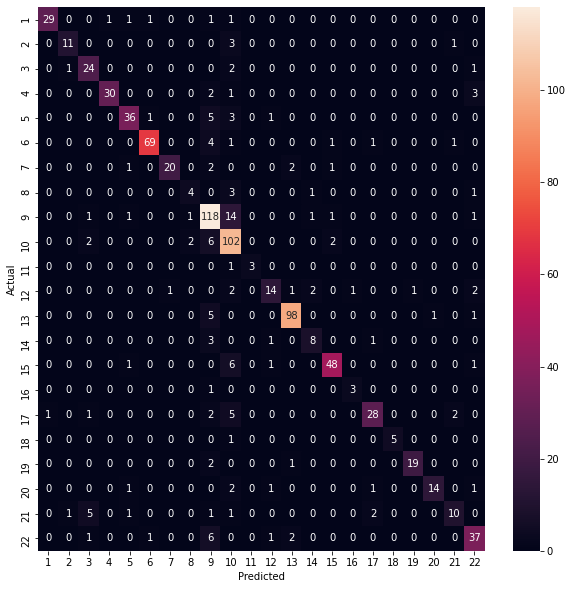

In [18]:
print(classification_report(y_test, ada.predict(x_test), target_names=a))
cfm_ada = confusion_matrix(y_test, ada.predict(x_test))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cfm_ada, annot=True, fmt='d',
            xticklabels=a, yticklabels=a)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Frequency domain feature extraction

In [5]:
cols = ['x_mean','y_mean','z_mean','x_median','y_median','z_median','x_min','y_min','z_min','x_max','y_max',\
        'z_max','mag_mean','mag_min','mag_max','mag_median', 'dist_mean_x', 'dist_mean_y', 'dist_mean_z', 'time_diff',\
        'fft_x_mean','fft_y_mean','fft_z_mean','fft_x_median','fft_y_median','fft_z_median',\
        'spec_cent_x','spec_cent_y','spec_cent_z',\
        'label']
feature_df_2 = pd.DataFrame(columns = cols)
for label in df.label.unique():
    dict_cols = {}
    one_label_df = df[df['label'] == label]
    windows = separate_windows(one_label_df)
    dict_cols = {'label':[label]*len(windows)}
    dict_cols.update(min_max_mean_each_component(windows))
    dict_cols.update(min_max_mean_magnitude(windows))
    dict_cols.update(distance_from_mean(windows))
    #dict_cols.update(cross_correlation(windows))
    dict_cols.update(avg_time_bw_obs(windows))
    dict_cols.update(fft_mean_each_component(windows))
    temp_df = pd.DataFrame(dict_cols)
    feature_df_2 = feature_df_2.append(temp_df, ignore_index=True)   
print(feature_df_2.head(5))
print (feature_df_2.columns)

     x_mean    y_mean    z_mean  x_median  y_median  z_median   x_min  \
0 -1.734232  4.632127  7.920713  -1.72980    3.8273   8.81240 -5.0940   
1  0.138899  6.795479  4.453044  -1.33480    6.5922   4.67180 -5.0940   
2  0.307064  8.404446  1.289750  -0.99429    8.6898   0.57205 -5.2030   
3 -2.143921  9.415441 -0.580550  -2.11120    9.4253  -0.65378 -5.2030   
4 -2.486993  9.265743 -0.782160  -2.56060    9.2346  -0.65378 -3.6775   

     y_min   z_min     x_max  ...  fft_x_mean  fft_y_mean  fft_z_mean  \
0  0.10896  1.9205   3.44590  ...   11.177007   20.892808   21.315726   
1  2.07030 -3.7592  10.14700  ...   20.209624   24.482907   24.538849   
2  2.07030 -3.7592  10.14700  ...   21.291579   23.943326   19.802783   
3  5.74780 -3.7592   0.50395  ...    9.434760   17.615901   11.664933   
4  8.43100 -2.9148  -1.07600  ...    5.381105   11.737035    4.901626   

   fft_x_median  fft_y_median  fft_z_median  spec_cent_x  spec_cent_y  \
0      7.105595      9.007213      6.800061   -11

In [6]:
dataframe = feature_df_2
features = dataframe.loc[:, dataframe.columns != 'label']
labels = dataframe['label']
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.30)

In [7]:
labels = list(set(feature_df_2.label.values))

# Logistic Regression

              precision    recall  f1-score   support

           1       0.71      0.65      0.68        26
           2       0.93      0.88      0.90        16
           3       0.62      0.54      0.58        28
           4       0.65      0.65      0.65        31
           5       0.64      0.81      0.71        31
           6       0.85      0.95      0.90        79
           7       0.90      0.78      0.84        23
           8       0.00      0.00      0.00         9
           9       0.53      0.64      0.58       121
          10       0.78      0.70      0.74       133
          11       0.75      0.43      0.55         7
          12       0.39      0.29      0.33        24
          13       0.81      0.92      0.86       100
          14       0.54      0.70      0.61        10
          15       0.62      0.76      0.69        59
          16       1.00      0.44      0.62         9
          17       0.74      0.48      0.58        42
          18       0.71    

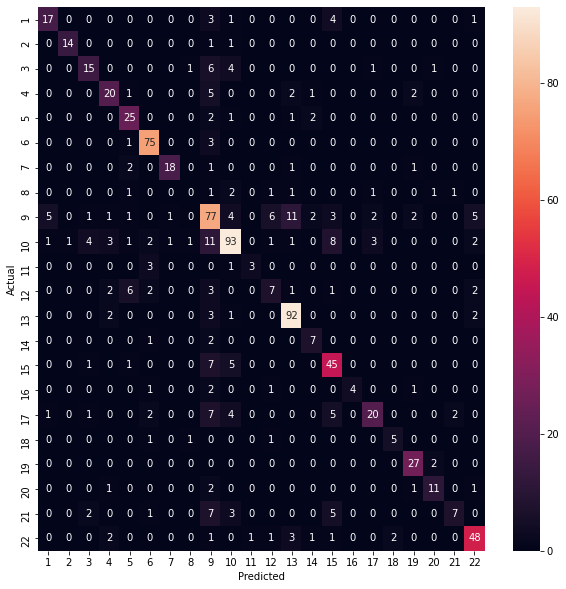

In [8]:
lr = OneVsRestClassifier(LogisticRegression())
lr = lr.fit(x_train, y_train)
scores = lr.predict(x_test)
a = sorted(labels,key = lambda x: int(x))
print(classification_report(y_test, lr.predict(x_test), target_names=a))
cfm_lr = confusion_matrix(y_test, lr.predict(x_test))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cfm_lr, annot=True, fmt='d',
            xticklabels=a, yticklabels=a)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Random Forest

In [9]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 100, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,15,25]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,6,8,10]
# Method of selecting samples for training each tree
bootstrap = [True, False]
random_grid = {'estimator__n_estimators': n_estimators,
               'estimator__max_features': max_features,
               'estimator__max_depth': max_depth,
               'estimator__min_samples_split': min_samples_split,
               'estimator__min_samples_leaf': min_samples_leaf,
               'estimator__bootstrap': bootstrap}
print(random_grid)

{'estimator__n_estimators': [20, 40, 60, 80, 100], 'estimator__max_features': ['auto', 'sqrt'], 'estimator__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'estimator__min_samples_split': [2, 5, 10, 15, 25], 'estimator__min_samples_leaf': [1, 2, 4, 6, 8, 10], 'estimator__bootstrap': [True, False]}


In [11]:
rf_randomCV = OneVsRestClassifier(RandomForestClassifier())
rf_random = RandomizedSearchCV(estimator = rf_randomCV, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random = rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.5min finished


              precision    recall  f1-score   support

           1       0.96      0.85      0.90        26
           2       1.00      0.81      0.90        16
           3       0.84      0.96      0.90        28
           4       0.88      0.90      0.89        31
           5       0.79      0.87      0.83        31
           6       0.88      0.95      0.91        79
           7       0.90      0.78      0.84        23
           8       1.00      0.44      0.62         9
           9       0.80      0.91      0.85       121
          10       0.87      0.89      0.88       133
          11       1.00      0.71      0.83         7
          12       0.73      0.46      0.56        24
          13       0.94      0.95      0.95       100
          14       0.67      0.80      0.73        10
          15       0.87      0.92      0.89        59
          16       1.00      0.67      0.80         9
          17       0.81      0.83      0.82        42
          18       1.00    

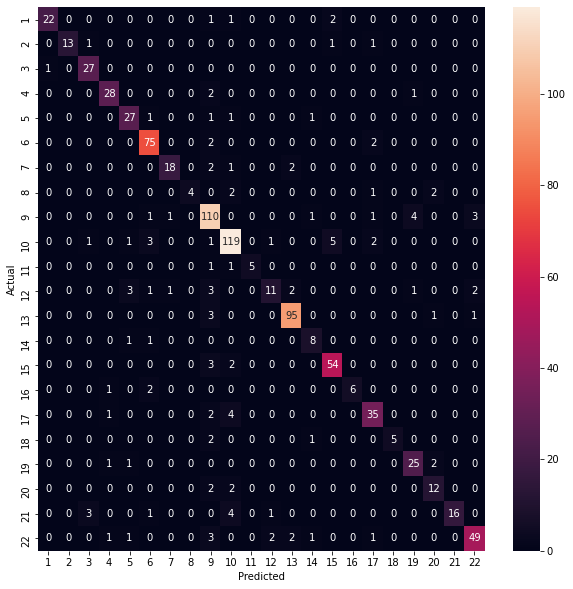

In [13]:
print(classification_report(y_test, rf_random.predict(x_test), target_names=a))
cfm_rf_random = confusion_matrix(y_test, rf_random.predict(x_test))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cfm_rf_random, annot=True, fmt='d',
            xticklabels=a, yticklabels=a)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Adaboost Classifier

In [18]:
ada = OneVsRestClassifier(AdaBoostClassifier(n_estimators=100, base_estimator=DecisionTreeClassifier(max_depth=5)))
ada = ada.fit(x_train,y_train)

In [21]:
ada = OneVsRestClassifier(AdaBoostClassifier(n_estimators=100, base_estimator=RandomForestClassifier(max_depth=2)))
ada = ada.fit(x_train,y_train)

In [25]:
y_prob = ada.predict_proba(x_test)

[36.99964244 32.73362333 57.42919032 40.17769182 57.83985237 35.66132341
 40.75261368 35.74388142 66.03969052 64.88494898  0.92989385 57.76109009
 53.65609554 43.10086695 59.54271002  3.8647357  58.54389515  1.33106951
 20.5041338  17.91508522 54.51719222 46.07077363]


0.9637639311718921
              precision    recall  f1-score   support

           1       1.00      0.81      0.89        26
           2       1.00      0.88      0.93        16
           3       0.93      0.89      0.91        28
           4       1.00      0.87      0.93        31
           5       0.85      0.94      0.89        31
           6       0.95      0.94      0.94        79
           7       1.00      0.78      0.88        23
           8       1.00      0.33      0.50         9
           9       0.72      0.96      0.82       121
          10       0.81      0.91      0.86       133
          11       1.00      0.43      0.60         7
          12       0.76      0.54      0.63        24
          13       0.95      0.95      0.95       100
          14       0.73      0.80      0.76        10
          15       0.85      0.93      0.89        59
          16       1.00      0.33      0.50         9
          17       0.90      0.86      0.88        42
        

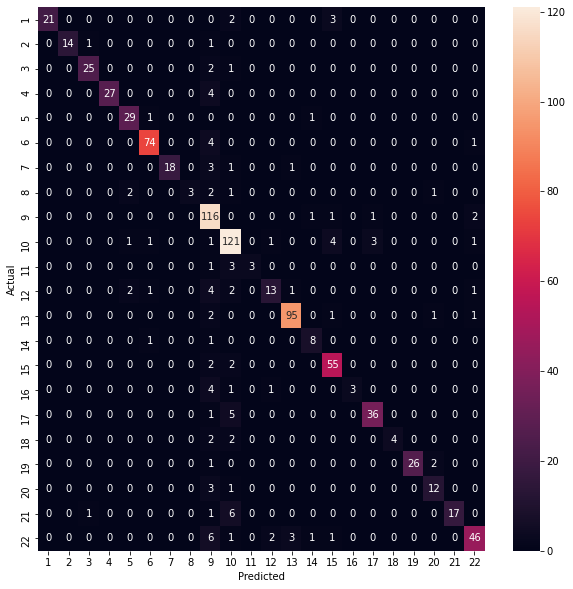

In [29]:
print (metrics.roc_auc_score(y_test, y_prob,multi_class='ovr'))
print(classification_report(y_test, ada.predict(x_test), target_names=a))
cfm_ada = confusion_matrix(y_test, ada.predict(x_test))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cfm_ada, annot=True, fmt='d',
            xticklabels=a, yticklabels=a)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()